<a href="https://colab.research.google.com/github/revak18/ClassificationAlgorithms/blob/main/EarthEngine_Study_Reva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Intro to the Earth Engine Python API**

https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api



# Earth Engine API Code
- Import the Earth Engine library.
- Authenticate access (registration verification and Google account access).
- Initialize the API.

In [ ]:
import ee  #  Imports the Earth Engine Python API for geospatial analysis,
ee.Authenticate() # Start the authentication process, prompting you to log in to your Google account and select a GCP project to use
ee.Initialize(project='210313089991') #Initializes the Earth Engine client library

# A **FeatureCollection** in GEE groups **individual features** (geometry + properties) together, enabling efficient **manipulation (filter, sort, visualize)** of the entire set.


**Feature**:
Imagine each grid cell within a geographical region represents a feature. Each feature would contain:

- **Geometry**: This would be a point or polygon representing the specific
grid cell location.
- **Properties**: This would primarily include the PDSI value for that cell at a specific point in time.

**Feature Collection**:
Now, imagine combining information about PDSI values for all grid cells within the chosen region for a specific time period (e.g., a month, year). This collection of individual features (grid cells with PDSI values) forms a FeatureCollection in GEE.

This FeatureCollection allows for detailed analysis of drought conditions across the region.

In Google Earth Engine, **reduceRegion** applies a **reducer function** to a specific **region** within an **image**. This function summarizes the values of the image pixels within the region, returning a **dictionary** containing the calculated statistics or values (e.g., mean, sum, count). It allows you to efficiently extract and analyze data localized to specific areas within an image.

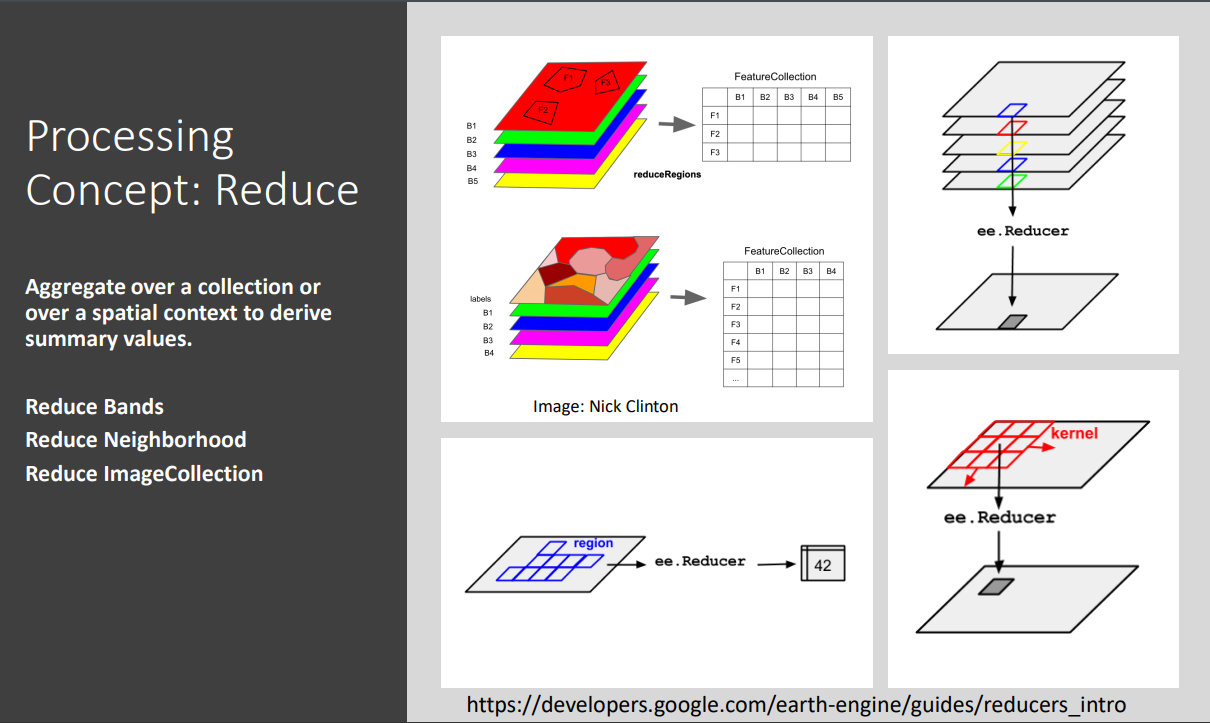

# Code to create a region reduction function
Reduction of pixels intersecting the region of interest to a statistic will be performed multiple times. Define a reusable function that can perform the task for each dataset. The function accepts arguments such as scale and reduction method to parameterize the operation for each particular analysis.

In [ ]:
"""
  Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
"""
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=5000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

    #Applies the ee.Image.reduceRegion() method.
    #Args:
    #  img: An ee.Image to reduce to a statistic by region.
    #Returns:
    #  An ee.Feature that contains properties representing the image region
    #  reduction results per band and the image timestamp formatted as
    #  milliseconds from Unix epoch (included to enable time series plotting).

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

# Code for function to transfer feature properties to a dictionary.

The result of the region reduction function above applied to an ee.ImageCollection produces an ee.FeatureCollection. This data needs to be transferred to the Python kernel, but serialized feature collections are large and awkward to deal with. This step defines a **function to convert the feature collection to an ee.Dictionary** where the keys are feature property names and values are corresponding lists of property values, which pandas can deal with handily.

Extract the property values from the ee.FeatureCollection as a list of lists stored in an ee.Dictionary using reduceColumns().
Extract the list of lists from the dictionary.
Add names to each list by converting to an ee.Dictionary where keys are property names and values are the corresponding value lists.
The returned ee.Dictionary is essentially a table, where keys define columns and list elements define rows.

In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  #print(fc.first().getInfo())
  #print('------------------')
  prop_names = fc.first().propertyNames()
  print('inside fc_to_dict...')
  print('prop_names:', prop_names.getInfo())
  #prop_lists = fc.reduceColumns(
  #    reducer=ee.Reducer.toList().repeat(prop_names.size()),
  #    selectors=prop_names).get('list')
  #print('prop_lists:', prop_lists)
  #return ee.Dictionary.fromLists(prop_names, prop_lists)
  return 1

# Code for function to add date variables to DataFrame.

In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  return df

# Code for testing

In [ ]:
import pandas as pd

today = ee.Date(pd.to_datetime('today'))
print("today::", today)
date_range = ee.DateRange(today.advance(-3, 'months'), today)
print("date_range::", date_range)

In [ ]:
# Define Charlotte, NC coordinates
latitude = -80.8431267
longitude = 35.2270869

# Create a point geometry object
point = ee.Geometry.Point(longitude, latitude)

# Define buffer distance (adjust as needed)
buffer_distance = 10000  # meters

# Create a buffer zone around the point
aoi = point.buffer(buffer_distance)

# Print the resulting geometry object
print(aoi.getInfo())

{'type': 'Polygon', 'coordinates': [[[35.227086899999996, -80.75313804048518], [35.07060638812375, -80.7566857061124], [34.92624618881305, -80.76705404443605], [34.80526367930632, -80.78343860563957], [34.71722917263172, -80.8045628504672], [34.66928440442446, -80.82877129147495], [34.665535303397675, -80.85415319280999], [34.70663739064165, -80.87868947509834], [34.78963242731853, -80.90041282779671], [34.90808376826541, -80.91756860500222], [35.05253241781759, -80.9287624541459], [35.21125734753227, -80.93308043734903], [35.37127871401535, -80.93016912642659], [35.51950177457134, -80.9202668669652], [35.64387383992884, -80.90418267655755], [35.73442418127727, -80.8832251691155], [35.78407817267302, -80.85908937734494], [35.7891756147765, -80.83371341566975], [35.74966822233223, -80.80911904654472], [35.66901163440675, -80.78725036975636], [35.55379557222066, -80.76982346071146], [35.41316961266593, -80.75819746388756], [35.25812365230586, -80.75327500820863], [35.227086899999996, -80

In [ ]:
pdsi = ee.ImageCollection('GRIDMET/DROUGHT').filterDate(date_range).select('pdsi')

In [ ]:
pdsi.first().bandNames().getInfo()

['pdsi']

In [ ]:
pdsi.first().propertyNames().getInfo()

['system:time_start',
 'system:footprint',
 'system:time_end',
 'system:version',
 'system:id',
 'system:asset_size',
 'status',
 'system:index',
 'system:bands',
 'system:band_names']

Reduce data
- Create a region reduction function.
- Map the function over the pdsi image collection to reduce each image.
- Filter out any resulting features that have null computed values (occurs when all pixels in an AOI are masked).

In [ ]:
reduce_pdsi = create_reduce_region_function(
    geometry=point, reducer=ee.Reducer.mean(), scale=5000, crs='EPSG:3310')

pdsi_stat_fc = ee.FeatureCollection(pdsi.map(reduce_pdsi)).filter(
    ee.Filter.notNull(pdsi.first().bandNames()))

In [ ]:
pdsi_stat_fc.getInfo()

The ee.FeatureCollection needs to be converted to a dictionary and transferred to the Python kernel.

- Apply the fc_to_dict function to convert from ee.FeatureCollection to ee.Dictionary.
- Call getInfo() on the ee.Dictionary to transfer the data client-side.

In [ ]:
pdsi_dict = fc_to_dict(pdsi_stat_fc).getInfo()

print(type(pdsi_dict), '\n')
for prop in pdsi_dict.keys():
    print(prop + ':', pdsi_dict[prop][0:3] + ['...'])

In [ ]:
import ee
import geemap
import datetime
import pandas as pd

# Authenticate to Earth Engine
#ee.Authenticate()
#ee.Initialize()

# Define the region of interest (ROI)
roi = ee.Geometry.Point(-75.98, 39.87)  # Example coordinates (replace with your own)

# Define the time range
start_date = '2020-01-01'
end_date = '2020-03-31'

# Load the PDSI dataset (example: from the Climate Engine collection)
pdsi_collection = ee.ImageCollection('GRIDMET/DROUGHT')
#pdsi = ee.ImageCollection('GRIDMET/DROUGHT').filterDate(date_range).select('pdsi')

first_image = pdsi_collection.first()
band_names = first_image.bandNames().getInfo()
print("Band names:", band_names)



Band names: ['pdsi', 'z', 'eddi14d', 'eddi30d', 'eddi90d', 'eddi180d', 'eddi270d', 'eddi1y', 'eddi2y', 'eddi5y', 'spi14d', 'spi30d', 'spi90d', 'spi180d', 'spi270d', 'spi1y', 'spi2y', 'spi5y', 'spei14d', 'spei30d', 'spei90d', 'spei180d', 'spei270d', 'spei1y', 'spei2y', 'spei5y']


In [ ]:
pdsi_band = 'pdsi'  # Change this to the appropriate band name in the collection

# Filter by date and location
filtered_pdsi = pdsi_collection.filterDate(start_date, end_date).filterBounds(roi)

# Extract image data as a list of dictionaries
pdsi_list = filtered_pdsi.toList(filtered_pdsi.size())
data_list = []

for i in range(filtered_pdsi.size().getInfo()):
    image = ee.Image(pdsi_list.get(i))
    date = datetime.datetime.utcfromtimestamp(image.get('system:time_start').getInfo() / 1000.0).strftime('%Y-%m-%d')
    value = image.reduceRegion(ee.Reducer.first(), roi).get(pdsi_band).getInfo()
    data_list.append({'Date': date, 'PDSI': value})

# Create a Pandas DataFrame
df = pd.DataFrame(data_list)

# Print the DataFrame
print(df)


          Date  PDSI
0   2020-01-05  2.62
1   2020-01-10  2.55
2   2020-01-15  2.45
3   2020-01-20  2.33
4   2020-01-25  2.33
5   2020-01-30  2.27
6   2020-02-04  2.22
7   2020-02-09  2.24
8   2020-02-14  2.28
9   2020-02-19  2.34
10  2020-02-24  2.27
11  2020-02-29  2.25
12  2020-03-05  2.21
13  2020-03-10  2.12
14  2020-03-15  1.99
15  2020-03-20  1.89
16  2020-03-25  1.84
17  2020-03-30  1.77


In [ ]:
import ee  #  Imports the Earth Engine Python API for geospatial analysis,
ee.Authenticate() # Start the authentication process, prompting you to log in to your Google account and select a GCP project to use
ee.Initialize(project='210313089991') #Initializes the Earth Engine client library

import pandas as pd  #Handles tabular data loading, manipulation, and analysis
import altair as alt #Creates interactive and expressive data visualizations.
import numpy as np  #Provides efficient array-based computing for numerical operations.
import folium #Creates interactive web maps
import requests #Makes HTTP requests to fetch data from APIs or websites.
import json #Works with JSON-formatted data.
import geopandas as gpd  #Extends pandas with geospatial capabilities for working with geographic data.
import seaborn as sns #Creates statistical graphics based on Matplotlib.

In [ ]:
## FTM Data: https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0001-2
## FTM Metadata: https://www.fs.usda.gov/rds/archive/products/RDS-2020-0001-2/_metadata_RDS-2020-0001-2.html

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File path in your Google Drive
file_path = '/content/drive/My Drive/FTM_fires.csv'

# Load FTM_fires.csv into Pandas DataFrame
df_FTM_fires = pd.read_csv(file_path)
print(df_FTM_fires.head(1))

# File path in your Google Drive
file_path = '/content/drive/My Drive/FTM_trees.csv'

# Load FTM_fires.csv into Pandas DataFrame
df_FTM_trees = pd.read_csv(file_path,low_memory=False)
print(df_FTM_trees.head(1))

Mounted at /content/drive
             YrFireName           Fire Dataset    N  yr_fire   Latitude  \
0  1981 - Manning Basin  Manning Basin   Brown  465     1981  42.602739   

    Longitude  Elevation  month_fire  day_fire Fire_type  State  \
0 -111.119003       2028         9.0      22.0        RX  Idaho   

     Sample_design Plot_size_ha   Threshold_diameter_cm  \
0  Fixed-area plot      0.01815  0 (every tree counted)   

                            Study_purpose  
0  Fuel Treatment Effects; Tree Mortality  
      YrFireName Species   Dataset  Times_burned   ID Plot TreeNum Unit Genus  \
0  2006 - Tripod   2TREE  Prichard             1  NaN  188      15  NaN   NaN   

  Species_name  ... IPS MPB  RPB  RTB  SB  WPB  WB  SPB  CVS_percent_source  \
0          NaN  ... NaN NaN  NaN  NaN NaN  NaN NaN  NaN                   F   

   CVK_percent_source  
0                 NaN  

[1 rows x 64 columns]


In [ ]:
for index, row in df_FTM_fires.iterrows():
    # Create a buffer around the coordinate (e.g., 1 km radius)
    print('index:', index, '::', row['YrFireName'], row['State'], row['Longitude'], row['Latitude'])
    point = ee.Geometry.Point(row['Longitude'], row['Latitude'])

In [ ]:
from itertools import combinations
import pandas as pd

def print_combination_dataframes(df, k):
  """
  Prints the dataframes for all unique k-combinations of column names.

  Args:
      df: The pandas dataframe.
      k: The number of columns in each combination.
  """
  for combination in get_k_combinations(df, k):
    print(f"Combination: {combination}")
    print(df[combination])
    print("----")

def get_k_combinations(df, k):
  """
  Returns a dataframe containing all unique k-combinations of column names.

  Args:
      df: The pandas dataframe.
      k: The number of columns in each combination.

  Returns:
      A pandas dataframe with k-combinations as rows and column names as columns.
  """
  return pd.DataFrame(combinations(df.columns, k), columns=df.columns[:k])

# Example usage
df = pd.DataFrame({'A': [1, 2, 3], 'B': ['a', 'b', 'c'], 'C': [True, False, True]})
print_combination_dataframes(df, 2)


Combination: A
0    1
1    2
2    3
Name: A, dtype: int64
----
Combination: B
0    a
1    b
2    c
Name: B, dtype: object
----


In [ ]:
import pandas as pd
import glob
from google.colab import drive
drive.mount('/content/drive/')




Mounted at /content/drive/


In [ ]:
dfs = pd.read_csv('/content/drive/MyDrive/NBR_FINAL/NBR_0_DIXIE_FIRE.csv')

dfs.head()

,NBR,millis,system:index,Timestamp,Year,Month,YrFireName,Dataset,yr_fire,Longitude,Latitude
0,0.200097,1579027527587,1_1_LC08_044032_20200114,2020-01-14 18:45:27.587,2020,1,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
1,0.192273,1581792318853,1_1_LC08_044032_20200215,2020-02-15 18:45:18.853,2020,2,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
2,0.224002,1583174714041,1_1_LC08_044032_20200302,2020-03-02 18:45:14.041,2020,3,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
3,0.221639,1585939497232,1_1_LC08_044032_20200403,2020-04-03 18:44:57.232,2020,4,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
4,0.248939,1588704282065,1_1_LC08_044032_20200505,2020-05-05 18:44:42.065,2020,5,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727


In [ ]:
import os # operating system
import pandas as pd
file_path = '/content/drive/MyDrive/NBR_FINAL/'

filelist=[]

for file in os.listdir(file_path):
  if file.startswith('NBR_'):
    filelist.append(file)

#print(filelist)

df = pd.DataFrame()
FTM_Dixie = []
dfs = []
k = 1
for i in filelist:
  str = file_path+i
  print("file: ", str)
  df = pd.read_csv(str)
  dfs.append(df)
  k = k + 1
  '''if k > 90:
    break'''

FTM_Dixie = pd.concat(dfs, ignore_index=True)
FTM_Dixie.head()

file:  /content/drive/MyDrive/NBR_FINAL/NBR_0_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_1_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_2_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_3_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_4_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_5_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_6_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_7_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_8_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_9_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_10_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_11_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_12_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_13_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_14_DIXIE_FIRE.csv
file:  /content/drive/MyDrive/NBR_FINAL/NBR_15_DIXIE_FIRE.csv
file:  /content/dr

,NBR,millis,system:index,Timestamp,Year,Month,YrFireName,Dataset,yr_fire,Longitude,Latitude
0,0.200097,1579027527587,1_1_LC08_044032_20200114,2020-01-14 18:45:27.587,2020,1,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
1,0.192273,1581792318853,1_1_LC08_044032_20200215,2020-02-15 18:45:18.853,2020,2,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
2,0.224002,1583174714041,1_1_LC08_044032_20200302,2020-03-02 18:45:14.041,2020,3,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
3,0.221639,1585939497232,1_1_LC08_044032_20200403,2020-04-03 18:44:57.232,2020,4,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727
4,0.248939,1588704282065,1_1_LC08_044032_20200505,2020-05-05 18:44:42.065,2020,5,DIXIE_FIRE_2021,NaN,2021,-121.429498,39.853727


In [ ]:
FTM_Dixie.Year.unique()
#NBR = FTM_Dixie[FTM_Dixie['Year'] == 2020]['NBR'].tolist()
#print(len(NBR))
year_counts = FTM_Dixie['Year'].value_counts()
print(year_counts)

2020    1200
2021    1199
2022    1158
2023    1091
Name: Year, dtype: int64


In [ ]:
rolling_mean = FTM_Dixie['NBR'].rolling(window=3,min_periods=1).mean()
FTM_Dixie['Rolling_Mean_3MO'] = rolling_mean

rolling_mean = FTM_Dixie['NBR'].rolling(window=6,min_periods=1).mean()
FTM_Dixie['Rolling_Mean_6MO'] = rolling_mean

rolling_mean = FTM_Dixie['NBR'].rolling(window=9,min_periods=1).mean()
FTM_Dixie['Rolling_Mean_9MO'] = rolling_mean

rolling_mean = FTM_Dixie['NBR'].rolling(window=12,min_periods=1).mean()
FTM_Dixie['Rolling_Mean_12MO'] = rolling_mean

rolling_mean = FTM_Dixie['NBR'].rolling(window=108,min_periods=1).mean()
FTM_Dixie['Rolling_Mean_108MO'] = rolling_mean

In [ ]:
FTM_Dixie.columns

Index(['NBR', 'millis', 'system:index', 'Timestamp', 'Year', 'Month',
       'YrFireName', 'Dataset', 'yr_fire', 'Longitude', 'Latitude',
       'Rolling_Mean_3MO', 'Rolling_Mean_6MO', 'Rolling_Mean_9MO',
       'Rolling_Mean_12MO', 'Rolling_Mean_108MO'],
      dtype='object')

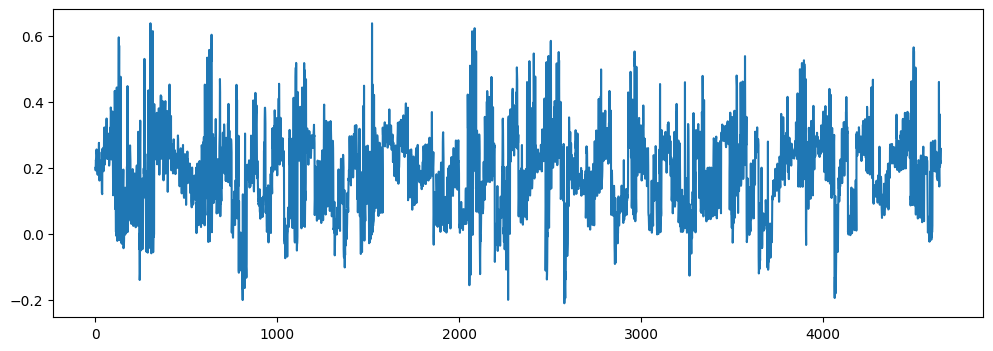

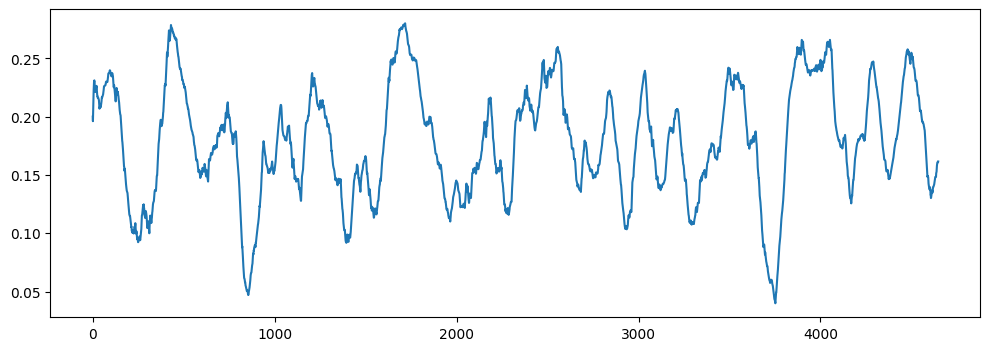

In [ ]:
# Rolling Mean graph

import matplotlib.pyplot as plt

#FTM_Dixie.plot(figsize=(12, 4))

FTM_Dixie['NBR'].plot(kind='line', figsize=(12, 4))  # Replace 'line' with other plot types like 'bar', 'scatter', etc.
plt.show()
FTM_Dixie['Rolling_Mean_108MO'].plot(kind='line', figsize=(12, 4))  # Replace 'line' with other plot types like 'bar', 'scatter', etc.
plt.show()



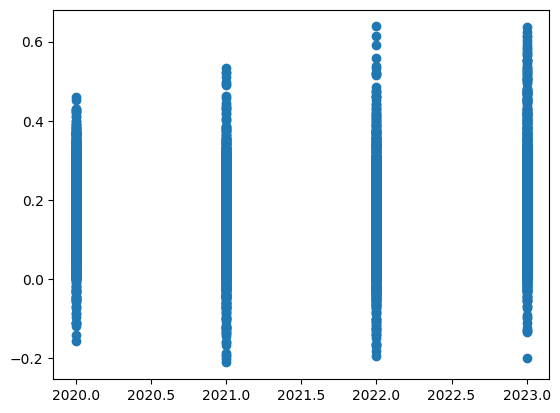

In [ ]:
plt.scatter(FTM_Dixie['Year'], FTM_Dixie['NBR'])
plt.show()

In [ ]:
import statistics

my_list = [1, 2, 3, 4, 5]
avg = statistics.mean(my_list)
print(avg)  # Output: 3.0


3


In [ ]:
filtered_df_2020 = FTM_Dixie[(FTM_Dixie['Year'] == 2020) & (FTM_Dixie['Month'].between(7, 12))].copy()
filtered_df_2020 = filtered_df_2020[['Year','Month','yr_fire', 'Longitude', 'Latitude', 'Rolling_Mean_6MO']]
#filtered_df_2020.head(15)
#filtered_df_2020.columns

filtered_loc1 = filtered_df_2020[(filtered_df_2020['Longitude'] == -121.429498) & (filtered_df_2020['Latitude'] == 39.853727)].copy()
filtered_loc1.head()

,Year,Month,yr_fire,Longitude,Latitude,Rolling_Mean_6MO


In [ ]:
pre_fire = []

for i in filtered_df_2020['Rolling_Mean_6MO']:
  pre_fire.append(i)
  print(i)

#pre_fire_NBR = statistics.mean(pre_fire)
#print('Pre - Fire NBR:', pre_fire_NBR)

Accuracy: 0.94


[Text(0.5, 0.875, 'x[0] <= -0.365\ngini = 0.666\nsamples = 400\nvalue = [140, 131, 129]\nclass = Cluster 1'),
 Text(0.25, 0.625, 'x[1] <= 4.36\ngini = 0.148\nsamples = 124\nvalue = [10, 0, 114]\nclass = Cluster 3'),
 Text(0.125, 0.375, 'x[0] <= -0.472\ngini = 0.019\nsamples = 107\nvalue = [1, 0, 106]\nclass = Cluster 3'),
 Text(0.0625, 0.125, 'gini = 0.0\nsamples = 104\nvalue = [0, 0, 104]\nclass = Cluster 3'),
 Text(0.1875, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [1, 0, 2]\nclass = Cluster 3'),
 Text(0.375, 0.375, 'x[0] <= -1.003\ngini = 0.498\nsamples = 17\nvalue = [9, 0, 8]\nclass = Cluster 1'),
 Text(0.3125, 0.125, 'gini = 0.32\nsamples = 10\nvalue = [2, 0, 8]\nclass = Cluster 3'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 7\nvalue = [7, 0, 0]\nclass = Cluster 1'),
 Text(0.75, 0.625, 'x[1] <= 2.573\ngini = 0.55\nsamples = 276\nvalue = [130, 131, 15]\nclass = Cluster 2'),
 Text(0.625, 0.375, 'x[1] <= 1.525\ngini = 0.113\nsamples = 135\nvalue = [4, 127, 4]\nclass = Cluster 2'),


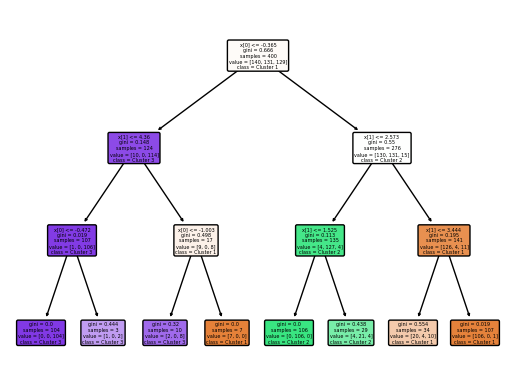

In [ ]:
# Import libraries
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Generate sample data with two features and three clusters
X, y = make_blobs(n_samples=500, centers=3, n_features=2, random_state=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth=3)  # Limit tree depth for visualization

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Visualize the decision tree
plot_tree(clf, filled=True, rounded=True, class_names=["Cluster 1", "Cluster 2", "Cluster 3"])
